In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
## Visualizing reconstructions
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name + '_vis.png')
    plt.show()

In [ ]:
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500
corruption_level = 0.3

# create node for input data
X = tf.placeholder("float", [None, n_visible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, n_visible], name='mask')

# create nodes for hidden variables
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')


def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # corrupted X

    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    return Z

# build model graph
Z = model(X, mask, W, b, W_prime, b_prime)

# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

In [ ]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, teX.shape)
        print(i, sess.run(cost, feed_dict={X: teX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]

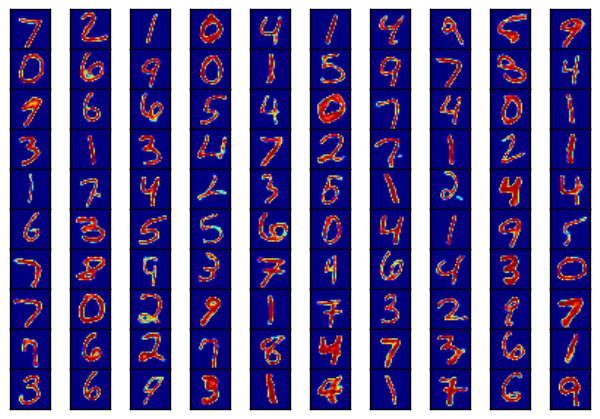

In [6]:
# Plot the reconstructed images
vis(predicted_imgs,'pred')

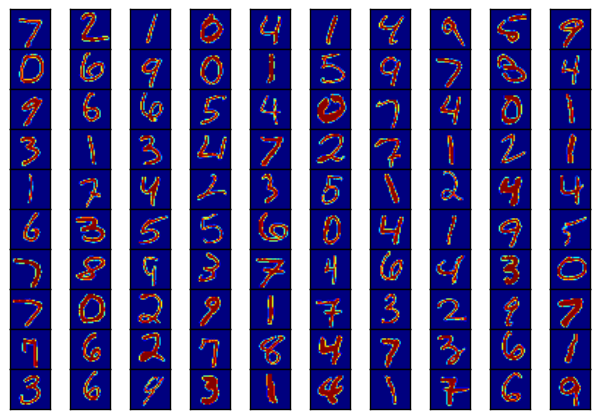

In [7]:
# Plot input images to compare with
vis(input_imgs,'in')